This notebook performs the synthesis using our proposed synthesization approach applied to the IPUMS data. The synthesis model is a CART. Logistic regression with three way interactions is used as the pMSE model.

In [1]:
from numpy.random import default_rng
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import itertools
import os
import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from helper_functions import *

rng = np.random.RandomState(42)

Import the data.

In [2]:
# import standardized lat/long location data
adv_data = pd.read_csv("adv_data.csv")

In [3]:
adv_data

,incwage,years_of_educ,potential_experience,non_white,sex
0,8.824678,12.000000,13.000000,0,0
1,8.006368,11.000000,1.000000,0,1
2,9.942708,13.000000,4.000000,0,0
3,8.987197,12.000000,13.000000,0,1
4,10.691945,16.000000,36.000000,1,1
...,...,...,...,...,...
66244,8.935904,12.000000,5.000000,1,0
66245,8.070906,11.000000,1.000000,0,1
66246,11.598562,17.737673,27.262327,0,0
66247,9.210340,16.000000,3.000000,0,1


***

# Full Sequential Synthesis Driven by Bayesian Optimization

Write function to train all models and generate the synthetic dataset, then evaluate the pMSE ratio.

In [4]:
def train_models(#overall parameters
                 train_data,
                 number_synthetic_datasets,
                 # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                 number_gmm_initializations,
                 num_components_,
                 # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                 mb_non_white_,
                 mb_sex_):
    
    num_samples = train_data.shape[0]

    # normalized version of training data
    scaler = StandardScaler().fit(train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
    norm_train = train_data.copy()
    norm_train.loc[:,['incwage', 'years_of_educ', 'potential_experience']] = scaler.transform(norm_train.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, covariance_type='full', init_params="k-means++", random_state=rng).fit(norm_train.loc[:, ['incwage', 'years_of_educ', 'potential_experience']])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX, columns=['incwage', 'years_of_educ', 'potential_experience'])
        sXs.append(sX)

    ####################################################################################################
        
    ########### Code for non_white CART ##########
    cart_non_white = DecisionTreeClassifier(min_samples_leaf=mb_non_white_, random_state=rng)
    
    cart_non_white.fit(X=norm_train.loc[:, ['incwage', 'years_of_educ', 'potential_experience']], y=norm_train.loc[:, "non_white"])
    
    node_indicators = cart_non_white.decision_path(norm_train.loc[:, ['incwage', 'years_of_educ', 'potential_experience']]).toarray()
    
    node_outcomes = [norm_train.loc[:, 'non_white'][node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    for i in range(number_synthetic_datasets):
        
        synth_leaves = cart_non_white.apply(sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']])
        
        new_non_white = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_non_white[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_non_white = pd.Series(new_non_white)
        
        new_non_white.name = "non_white"
        
        sXs[i] = pd.concat([sXs[i], new_non_white], axis=1)
    
    ####################################################################################################
        
    ########### Code for sex CART ##########
    
    cart_sex = DecisionTreeClassifier(min_samples_leaf=mb_sex_, random_state=rng)
    
    cart_sex.fit(X=norm_train.loc[:, ['incwage', 'years_of_educ', 'potential_experience', 'non_white']], y=norm_train.loc[:, "sex"])
    
    node_indicators = cart_sex.decision_path(norm_train.loc[:, ['incwage', 'years_of_educ', 'potential_experience', 'non_white']]).toarray()
    
    node_outcomes = [norm_train.loc[:, 'sex'][node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    for i in range(number_synthetic_datasets):
        
        synth_leaves = cart_sex.apply(sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience', 'non_white']])
        
        new_sex = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_sex[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_sex = pd.Series(new_sex)
        
        new_sex.name = "sex"
        
        sXs[i] = pd.concat([sXs[i], new_sex], axis=1)
        
    ###### Calculate ks distances ######
    pmse_ratios = [pmse_ratio(norm_train, Y) for Y in sXs]

    # convert sXs to original scale (un-normalize?)
    for i, Z in enumerate(sXs):
        H = train_data.sample(frac=1.0, replace=True, ignore_index=True).loc[:,['incwage', 'years_of_educ', 'potential_experience']]
        scaler = StandardScaler().fit(H)
        Z.loc[:,['incwage', 'years_of_educ', 'potential_experience']] = scaler.inverse_transform(Z.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
        Z.loc[:, ['years_of_educ']] = np.round(Z.loc[:, ['years_of_educ']], 0)
    
    return pmse_ratios, sXs, GMM

In [5]:
def optimize_models(train_data,
                    number_synthetic_datasets,
                    number_gmm_initializations,
                    random_state):

    def evaluate_models(num_components_, mb_non_white_, mb_sex_):

        pmse_ratios, _, _ = train_models(train_data=train_data,
                                         number_synthetic_datasets=number_synthetic_datasets,
                                         number_gmm_initializations=number_gmm_initializations,
                                         num_components_=int(num_components_),
                                         mb_non_white_=int(mb_non_white_),
                                         mb_sex_=int(mb_sex_))

        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (10, 200.99),
            "mb_non_white_": (10, 350.99),
            "mb_sex_": (10, 350.99)
        },
        random_state=random_state)

    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value of $\alpha = 1e-06$.

In [6]:
nsd = 10
ngi = 2
random_states = [np.random.RandomState(1006), np.random.RandomState(428)]

In [8]:
optimization_results = [optimize_models(train_data=adv_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   | mb_non... |  mb_sex_  | num_co... |
-------------------------------------------------------------
| 1         | -1.467    | 263.4     | 87.21     | 132.7     |
| 2         | -1.399    | 310.9     | 262.6     | 147.8     |
| 3         | -136.1    | 110.7     | 189.2     | 43.19     |
| 4         | -54.96    | 286.9     | 299.6     | 58.99     |
| 5         | -25.67    | 90.89     | 166.3     | 53.72     |
| 6         | -1.714    | 310.7     | 263.0     | 148.5     |
| 7         | -1.039    | 318.8     | 246.1     | 155.0     |
| 8         | -3.596    | 295.2     | 243.2     | 148.6     |
| 9         | -3.264    | 72.2      | 144.7     | 63.66     |
| 10        | -1.644    | 320.8     | 232.1     | 124.4     |
| 11        | -0.7404   | 276.2     | 120.2     | 133.6     |
| 12        | -3.946    | 296.6     | 94.83     | 119.2     |
| 13        | -0.7902   | 287.9     | 97.19     | 159.8     |
| 14        | -0.000134 | 250.6     | 111.7     | 165.0     |
| 15    

***

In [9]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

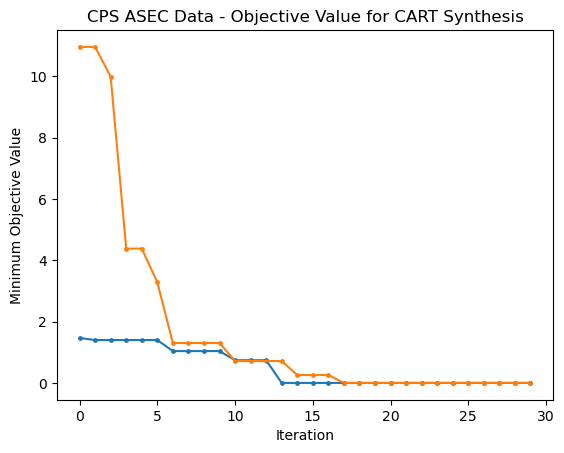

In [10]:
fig = plt.figure()
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("CPS ASEC Data - Objective Value for CART Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [11]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [12]:
best_params

{'target': -3.316083988675802e-05,
 'params': {'mb_non_white_': 203.21359460992954,
  'mb_sex_': 46.01747341257388,
  'num_components_': 200.99}}

***

Generate 20 synthetic datasets.

In [13]:
pmse_ratios, full_sXs, GMM = train_models(train_data=adv_data,
                                          number_synthetic_datasets=20,
                                          # hyperparameters for GMM
                                          number_gmm_initializations=ngi,
                                          num_components_=int(best_params['params']['num_components_']),
                                          # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                          mb_sex_=int(best_params['params']['mb_sex_']),
                                          mb_non_white_=int(best_params['params']['mb_non_white_']))

In [14]:
np.mean(pmse_ratios)

1.1778236094507093

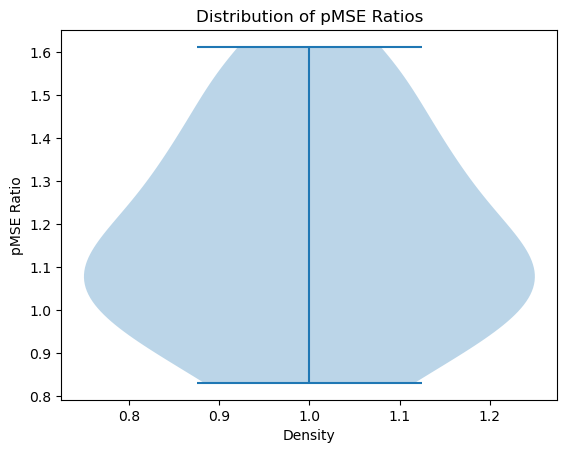

In [15]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

***

# Save the synthetic datasets.

In [16]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("synthetic_adv/sd_" + str(i) + ".csv", index=False)

***

In [18]:
# full_sXs = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_cart_" + str(i) + ".csv") for i in range(20)]

In [19]:
# # load
# with open('../Results/IPUMS/Models/gmm_and_cart.pkl', 'rb') as f:
#     GMM = pickle.load(f)

***

Now apply the attribute disclosure prevention algorithm.

We don't have a great baseline for the probability of being non-white, so we'll just use the proportion from the data.

In [20]:
# prior = np.mean(train_data.non_white == 1)

For our threshold, we select $c = 3$, i.e., we are allowing for a 3x increase in the probability of an adversary inferring the non-white status based on the synthetic data.

In [21]:
# prior

In [22]:
# c = 3

We provide a range of $\delta$ values over which to evaluate and prevent attribute disclosure.

In [23]:
# deltas = np.linspace(0.001, 0.1, 5)

In [24]:
# ad_sXs = [attribute_disclosure_reduction(original_data=train_data, 
#                                          synthetic_data=X,
#                                          continuous_vars=['incwage', 'years_of_educ', 'potential_experience'],
#                                          categorical_vars=['sex'],
#                                          sensitive_var='non_white',
#                                          mixture_model=GMM,
#                                          deltas=deltas, 
#                                          c=c, 
#                                          prior_prob=prior) for X in full_sXs]

***

In [25]:
# num_records = train_data.shape[0]

In [26]:
# np.mean([Z.shape[0] - num_records for Z in ad_sXs])

***

In [27]:
# for i, sX in enumerate(ad_sXs):

#     # normalize
#     sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']] = StandardScaler().fit_transform(sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
#     full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']] = StandardScaler().fit_transform(full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']])

#     # reverse the normalization using means/sds from bootstrap sampled confidential data
#     H = train_data.sample(frac=1.0, replace=True, ignore_index=True).loc[:,['incwage', 'years_of_educ', 'potential_experience']]
#     scaler = StandardScaler().fit(H)
#     sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']] = scaler.inverse_transform(sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
#     full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']] = scaler.inverse_transform(full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']])
#     sX.to_csv("../Data/IPUMS/Synthetic Datasets/ad_gmm_and_cart_" + str(i) + ".csv", index=False)
#     full_sXs[i].to_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_cart_" + str(i) + ".csv", index=False)

***